In [1]:
!nvidia-smi

Wed Feb 19 02:50:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pwd

/content


# 可视化中间激活

In [2]:
from keras.models import load_model
%tensorflow_version 1.x

Using TensorFlow backend.


In [3]:
model = load_model(r'./drive/My Drive/Data/dogs-vs-cats_small/cats_and_dogs_small_2.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [4]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [0]:
# 预处理单张图像

In [0]:
img_path = r'./drive/My Drive/Data/dogs-vs-cats_small/test/cats/cat.1700.jpg'

In [0]:
from keras.preprocessing import image
import numpy as np

In [0]:
img = image.load_img(path=img_path, target_size=(150, 150))

In [0]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [0]:
# 将图像预处理为一个4D张量

In [11]:
img_tensor.shape

(1, 150, 150, 3)

In [0]:
# 显示测试图像

In [0]:
import matplotlib.pyplot as plt

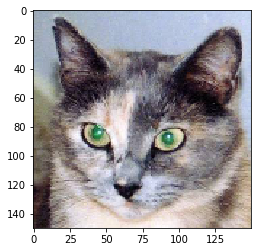

In [14]:
plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

In [0]:
# 模型实例化

In [0]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
# 以预测模式运行模型

In [0]:
activations = activation_model.predict(img_tensor)

In [20]:
len(activations)

8

In [0]:
first_layer_activation = activations[0]

In [22]:
print(first_layer_activation.shape)

(1, 148, 148, 32)


In [0]:
# 将第四个通道可视化

In [0]:
import matplotlib.pyplot as plt

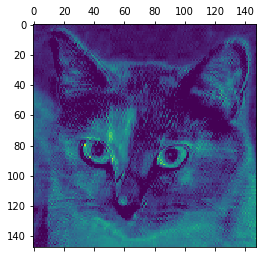

In [25]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [0]:
# 将第七个通道可视化

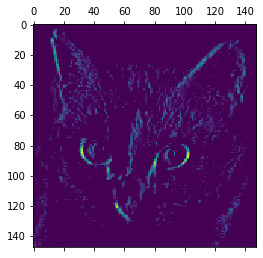

In [27]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [0]:
# 将每个中间激活的所有通道可视化

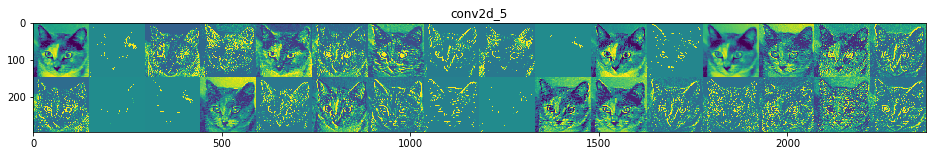

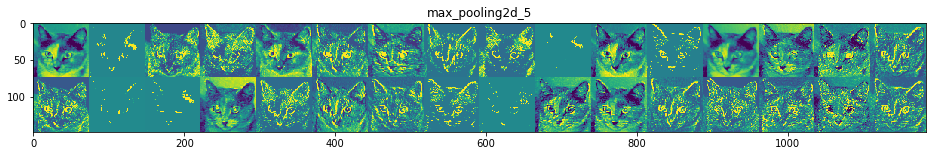

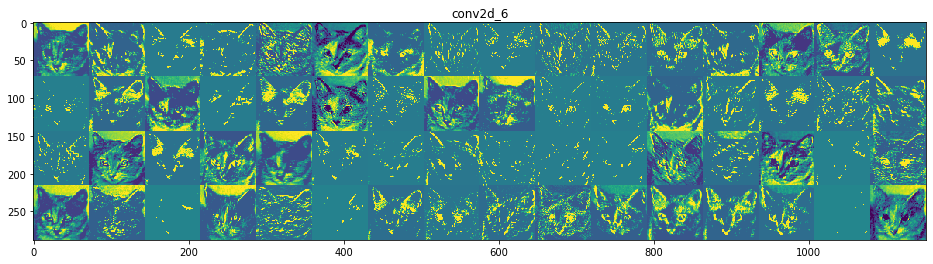

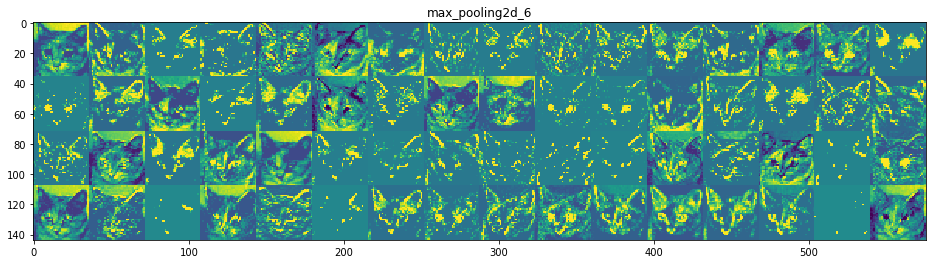

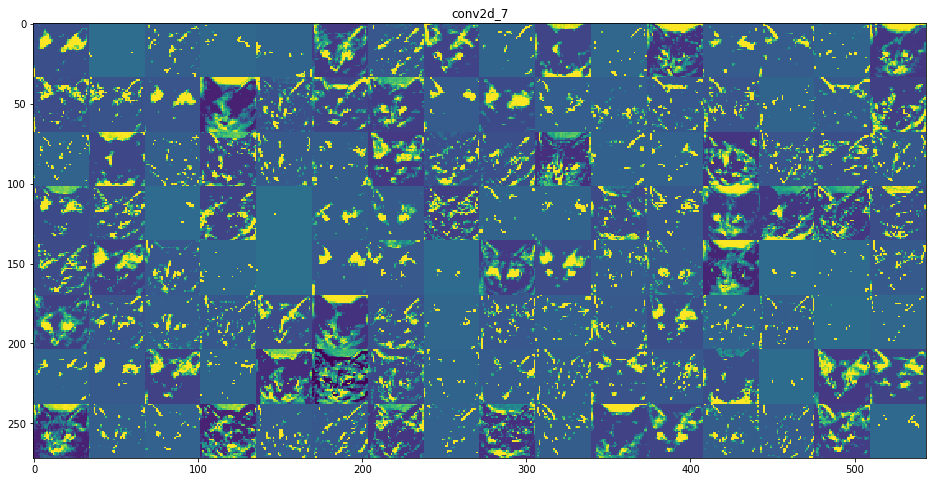

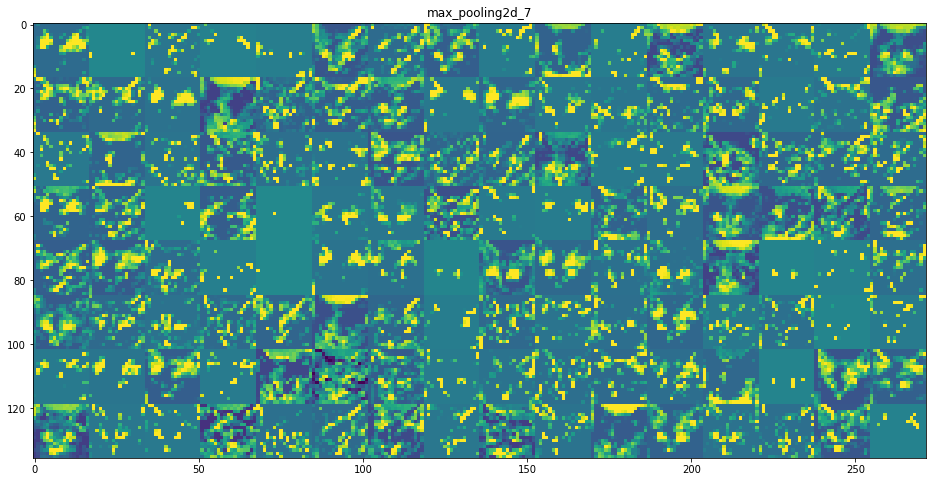

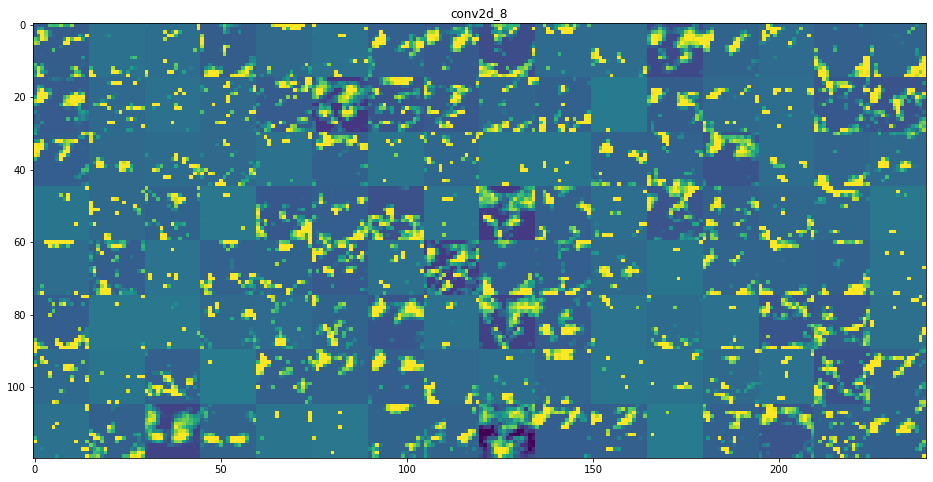

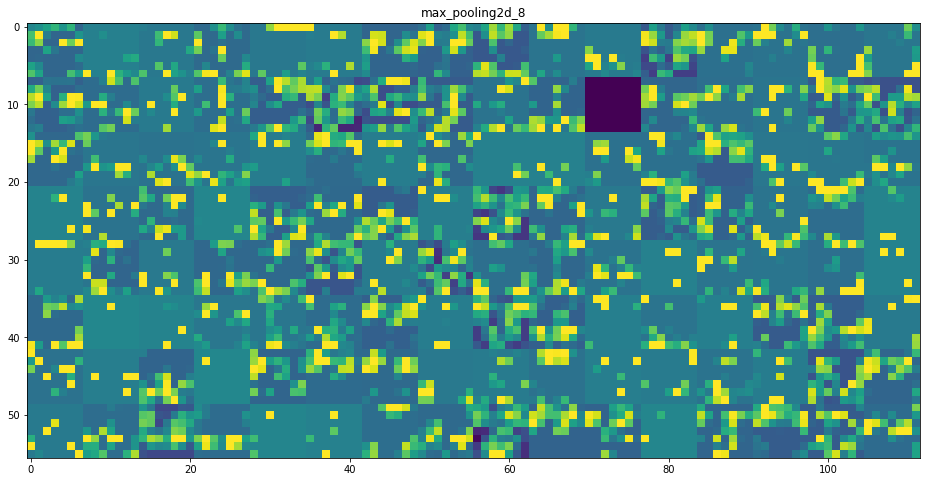

In [30]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  # 特征图的形状为[1, size, size, n_features]
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  # 显示网格
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

- 深度神经网络可以有效地作为信息蒸馏管道(information distillation pipeline)。其对输入数据进行反复变换，将无关信息过滤掉(比如图片的具体外观)，并放大和细化有用的信息(比如图像的类别)。

# 可视化卷积神经网络的过滤器

In [0]:
# block3_conv1第0个过滤器的可视化定义张量

In [5]:
from keras.applications import VGG16
from keras import backend as K

Using TensorFlow backend.


In [6]:
model = VGG16(weights='imagenet', include_top=False)

In [0]:
layer_name = 'block3_conv1'
filter_index = 0

In [0]:
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
# 获取损失相对于输入的梯度

In [0]:
grads = K.gradients(loss, model.input)[0]

In [0]:
# 梯度标准化技巧

In [0]:
grads /= (K.sqrt(K.mean(K.square(grads)) + 1e-5))  # 做除法前加上1e-5，以防不小心除以0

In [0]:
# 计算损失张量和梯度张量

In [0]:
iterate = K.function([model.input], [loss, grads])

In [0]:
import numpy as np

In [0]:
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
# 通过随机梯度下降让损失最大化

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

In [0]:
step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

In [0]:
# 将张量转换为有效图像的实用函数

In [0]:
def deprocess_image(x):
  # 对张量做标准化，均值为0，标准差为0.1
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  # 将x裁切(clip)到[0,1]之间
  x += 0.5
  x = np.clip(x, 0, 1)
  # 将x转换为RGB数组
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
# 生成过滤器可视化函数

In [0]:
# 构建一个损失函数，将该层第n个过滤器的激活最大化

In [0]:
def generate_pattern(layer_name, filter_index, size=500):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  
  img = input_img_data[0]
  return deprocess_image(img)

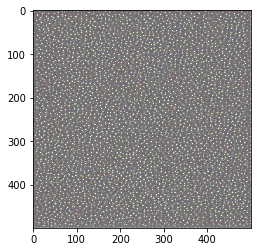

In [29]:
plt.imshow(generate_pattern(layer_name='block3_conv1', filter_index=0))
plt.show()

In [0]:
# 生成某一层中所有过滤器响应模式组成的网络

In [0]:
layer_name = 'block1_conv1'
size = 64
margin = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


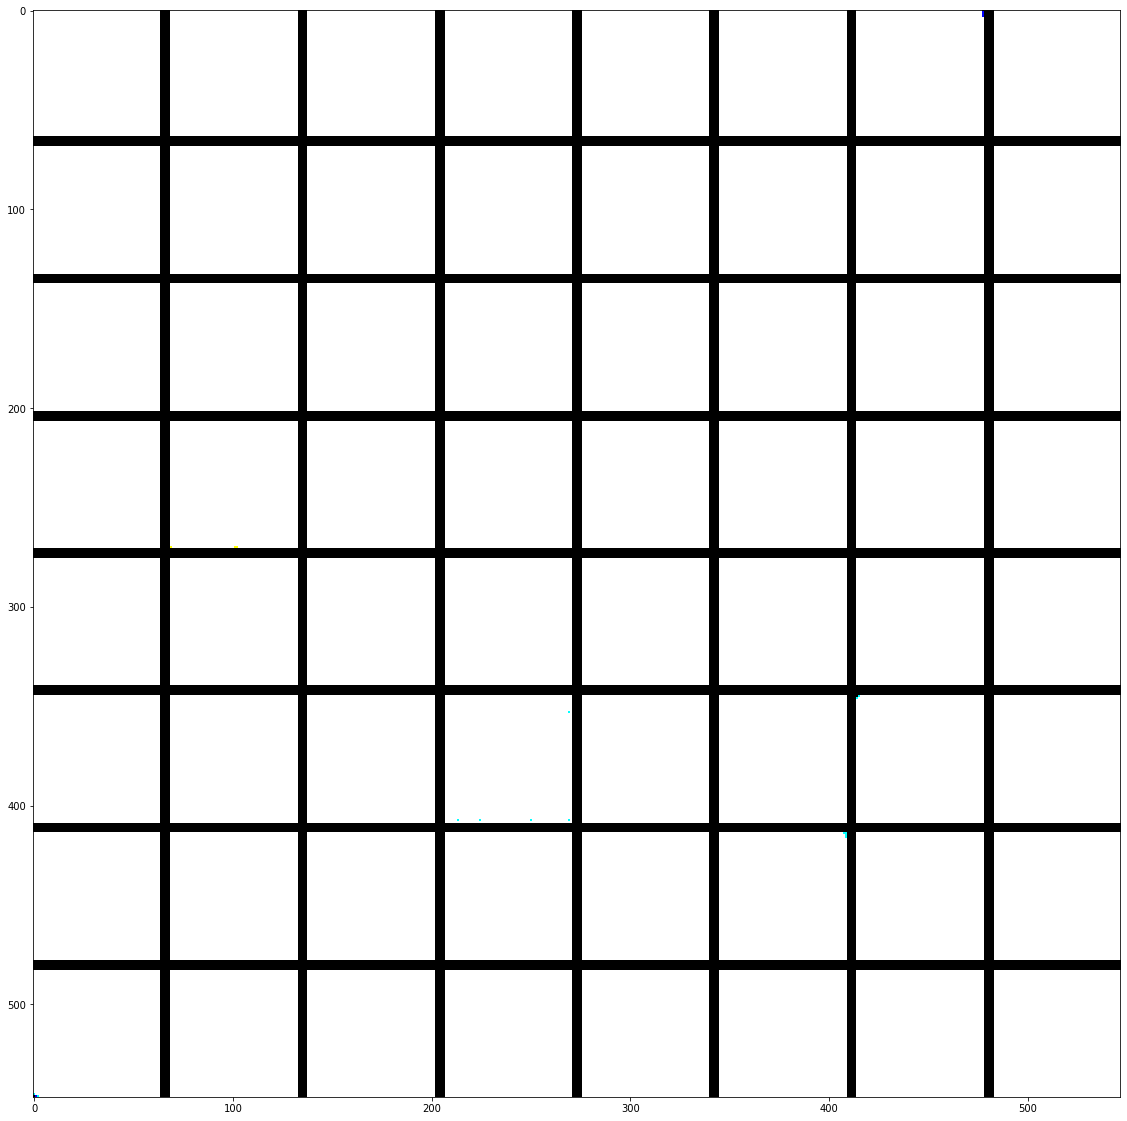

In [34]:
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

# 遍历results网络的行
for i in range(8):
  # 遍历results网络的列
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)  # size可以重新指定
    # 将结果放到results网络第(i, j)个方块中
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
# 显示results网格
plt.figure(figsize=(20, 20))
plt.imshow(results)

# 可视化类激活的热力图

In [0]:
# 加载带有训练权重的VGG16网络

In [0]:
from keras.applications import VGG16

In [37]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 39s 0us/step


In [39]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [45]:
!pwd

/content


In [0]:
img_path = r'./drive/My Drive/Data/creative_commons_elephant.jpg'

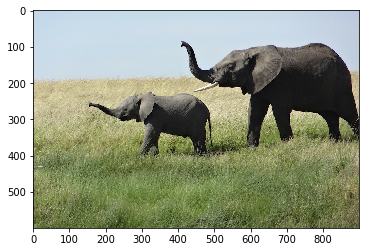

In [96]:
img1 = plt.imread(img_path)
plt.imshow(img1)
plt.show()

In [0]:
img = image.load_img(img_path, target_size=(224, 224))

In [0]:
x = image.img_to_array(img)

In [0]:
x = np.expand_dims(x, axis=0)

In [0]:
x = preprocess_input(x)

In [0]:
# 运行预训练的VGG16网络，并将其预测向量解码为人类可读格式

In [0]:
preds = model.predict(x)

In [55]:
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


In [56]:
np.argmax(preds[0])

386

In [0]:
# Grad_CAM算法展示图像中那部分最像非洲象

In [0]:
# 预测向量中的非洲象元素

In [0]:
african_elephant_output = model.output[:, 386]

In [0]:
# block5_conv3层的输出特征图是VGG16的最后一个卷积层

In [0]:
last_conv_layer = model.get_layer('block5_conv3')

In [0]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

In [0]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [0]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [0]:
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [0]:
# 为了便于可视化，，需要将热力图标准化到0-1自检

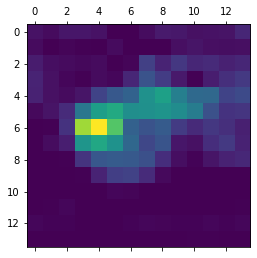

In [71]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [0]:
# 利用OpenCV将原始图像与上图叠加

In [0]:
import cv2

In [0]:
img = cv2.imread(img_path)

In [0]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [0]:
# 将热力图转换为RGB格式

In [0]:
heatmap = np.uint8(255 * heatmap)

In [0]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [0]:
superimposed_img = heatmap * 0.4 + img  # 这里的0.4是热力图强度因子

In [0]:
# 保存至云盘

In [81]:
cv2.imwrite('./drive/My Drive/Data/elephant_cam.jpg', superimposed_img)

True

In [0]:
import matplotlib.pyplot as plt

In [0]:
img2 = plt.imread(r'./drive/My Drive/Data/elephant_cam.jpg')

<function matplotlib.pyplot.show>

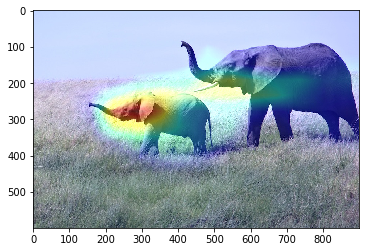

In [94]:
plt.imshow(img2)
plt.show